In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_set = pd.read_csv("train.csv", parse_dates=["date"])

train_set["date"] = pd.to_datetime(train_set["date"]) # converting the date column to pandas datetype

In [3]:
train_set_encoded = pd.get_dummies(train_set, columns=["family","store_nbr"])

train_set_encoded = train_set_encoded.drop(columns=["family_AUTOMOTIVE","store_nbr_1"])

In [4]:
y = train_set_encoded["sales"]

train_set_encoded = train_set_encoded.drop(columns="sales")

In [5]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

unique_dates = pd.date_range(start=train_set["date"].min(), end=train_set["date"].max(), freq="D")


# Using DeterministicProcess to generate time dummies (linear and quadratic with order=2) 
# and two Fourier elements for seasonal effects at yearly and weekly frequencies  

fourier1 = CalendarFourier(freq="YE", order=1)  
fourier2 = CalendarFourier(freq="W", order=1)  

train_set_copy = train_set.copy()
train_set_copy.set_index("date")

dp = DeterministicProcess(
    index=unique_dates,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    additional_terms=[fourier1,fourier2],  
    drop=True,           # drop terms if necessary to avoid collinearity
)

X_trend_season = dp.in_sample()

In [6]:
X = train_set_encoded.merge(X_trend_season, left_on="date", right_index=True, how="left")

In [ ]:
# X = X.set_index("date")

# X = X.drop(columns="id")

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)

In [11]:
y_pred = model.predict(X)

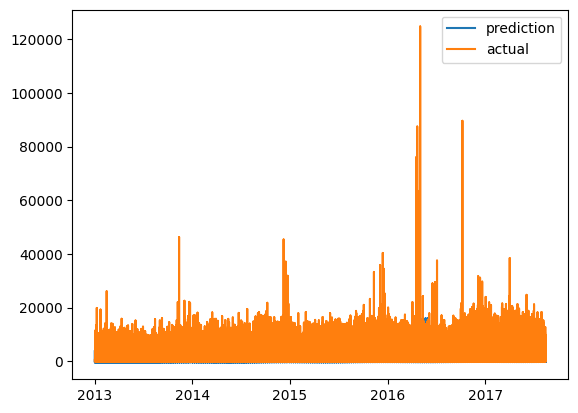

In [12]:
plt.plot(X.index,y_pred,label='prediction')
plt.plot(X.index,y,label='actual')
plt.legend()


In [13]:
test_set = pd.read_csv("test.csv",parse_dates=["date"])

test_set_encoded = pd.get_dummies(test_set, columns=["family","store_nbr"])

test_set_encoded = test_set_encoded.drop(columns=["family_AUTOMOTIVE","store_nbr_1"])

In [14]:
test_set

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [15]:
unique_dates_testset = pd.date_range(start=test_set["date"].min(), end=test_set["date"].max(), freq="D")


# Using DeterministicProcess to generate time dummies (linear and quadratic with order=2) 
# and two Fourier elements for seasonal effects at yearly and weekly frequencies  

fourier1 = CalendarFourier(freq="YE", order=1)  
fourier2 = CalendarFourier(freq="W", order=1)  

# test_set_copy = test_set.copy()
# test_set_copy.set_index("date")

dp = DeterministicProcess(
    index=unique_dates_testset,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    additional_terms=[fourier1,fourier2],  
    drop=True,           # drop terms if necessary to avoid collinearity
)

X_trend_season_test = dp.in_sample()

In [16]:
X_test = test_set_encoded.merge(X_trend_season_test, left_on="date", right_index=True, how="left")

In [ ]:
# index_series_test = test_set["id"]

# X_test = X_test.set_index("date")

# X_test = X_test.drop(columns="id")

# test_set

In [21]:
index_series_test

0        3000888
1        3000889
2        3000890
3        3000891
4        3000892
          ...   
28507    3029395
28508    3029396
28509    3029397
28510    3029398
28511    3029399
Name: id, Length: 28512, dtype: int64

In [22]:
y_test = model.predict(X_test)

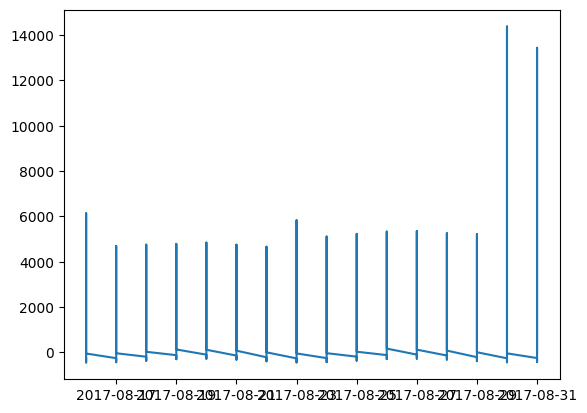

In [23]:
plt.plot(X_test.index, y_test)

In [44]:
X["id"] = y.index

In [51]:
y

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
3000883     438.133
3000884     154.553
3000885    2419.729
3000886     121.000
3000887      16.000
Name: sales, Length: 3000888, dtype: float64

In [49]:
X = X.reset_index().set_index("id")

In [52]:
X["date"][X["family_BABY CARE"]==1]

id
1         2013-01-01
34        2013-01-01
67        2013-01-01
100       2013-01-01
133       2013-01-01
             ...    
3000724   2017-08-15
3000757   2017-08-15
3000790   2017-08-15
3000823   2017-08-15
3000856   2017-08-15
Name: date, Length: 90936, dtype: datetime64[ns]

In [24]:
predictions = pd.DataFrame({
    "id": index_series_test,
    "sales": y_test
})

In [25]:
predictions.to_csv("predictions_trial1.csv",index=False)